# Notas sobre procesamiento digital de señales aplicado al análisis de vibraciones mecánicas

## Elaborado por Mag. Luis Sánchez Céspedes

In [ ]:
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft,ifft
from scipy import signal

from scipy.interpolate import CubicSpline

from line_profiler import LineProfiler

np.random.seed(1)
plt.style.use('classic')

In [29]:
def dft(signal):
    N = len(signal)
    dft_result = np.zeros(N, dtype=complex)
    
    for k in range(N):
        for n in range(N):
            dft_result[k] += signal[n] * np.exp(-2j * np.pi * k * n / N)
    series_fft = abs(dft_result)
    series_fft_half = series_fft[0:int(N//2)]
    
    return series_fft_half

def get_frequency_domain(series):
    series_fft = abs(np.fft.fft(series))
    series_fft_half = series_fft[0:int(len(series)//2)]

    return series_fft_half

def load_data(file_path="") -> str:
    input_data = np.genfromtxt(file_path, delimiter=",")
    thisdict = {}
    thisdict['input_data'] = {"data":input_data.tolist()}
    return json.dumps(thisdict)

def get_hilbert_transform(data):
    n = len(data)
    X = fft(data)
    H = np.zeros(n)

    if n % 2 == 0:
        H[0]=1
        H[1:n//2]=2
    else:
        H[0]=1
        H[1:(n+1)//2]=2

    H[(n//2)+1:]=0
    X_hat = X * H

    return ifft(X_hat)

def get_analytic_signal(data):
    return data + 1j * get_hilbert_transform(data)

def get_analytic_signal2(data):
    return signal.hilbert(data)

def get_amplitude_envelope(analytic_signal):
    return np.abs(analytic_signal)

def get_instantaneous_phase(analytic_signal):
    return np.angle(analytic_signal)

def get_intantaneous_frequency(instantaneous_phase, sampling_rate=50000):
    return np.diff(instantaneous_phase)*((2*np.pi)/sampling_rate)

# Objetivos

- Entender la evolución y propiedades que tuvo el análisis de Fourier.
- Entender en que consiste el FFT.
- Entender en que consiste la transforma de Hilbert y el análisis de la señal analítica.
- Entender en que consiste la decomposición empírica de modos (EMD).
- Ver ejemplos de la aplicación de estos algoritmos en vibraciones mecánicas.

# 1. Transformada Discreta de Fourier (DFT)

Joseph Fourier, considerado por muchos como el padre de la termodinámica presenta un artículo sobre transferencia de calor titulado "On the Temperatures of the Terrestrial Sphere and Interplanetary Space" (1827). Interesantemente este artículo es también considerado como uno de los primeros indicios sobre el efecto invernadero. Asimismo, es la primera vez que se presenta la teoría de series infinitas de Fourier.

Las series de Fourier se representan de la siguiente forma

$$
\begin{align}
C_n = \int_{\frac{-P}{2}}^{\frac{P}{2}} x(t) \cdot e^{-i2\pi f_n t} dt
\end{align}
$$

Y es usada para representar funciones periodicas y continuas. Por ejemplo senos, cosenos y cualquier forma de onda que se repita.

Este trabajo fue continuado por Peter Gustav Dirichlet, quien realiza dos modificaciones a las series de Fourier. Esta nueva iteración se conoce como la transformada de Fourier.

$$
\begin{align}
C_n = \int_{\frac{-P}{2}}^{\frac{P}{2}} x(t) \cdot e^{-i2\pi f_n t} dt
\end{align}
$$


La Transformada Discreta de Fourier en su forma exponencial se define como

$$
\begin{align}
X_k = \sum_{n=0}^{N-1} x_n \cdot e^{-i2\pi\frac{n}{N}}
\end{align}
$$

- La frecuencia es discreta, finita y está representada por la letra k
- El tiempo es discreto, finito y está representado por la letra n

Gracias a la formula de Euler

$$
\begin{align}
e^{i\theta} = \cos\theta + i\sin\theta
\end{align}
$$

Podemos representar DFT en forma polar

$$
\begin{align}
X_k = \sum_{n=0}^{N-1} x_n [\cos{i2\pi\frac{n}{N}} -i\sin{2\pi\frac{n}{N}}]
\end{align}
$$

Donde la parte real es

$$
\begin{align}
Re_{X_k} = \sum_{n=0}^{N-1} x_n [\cos{i2\pi\frac{n}{N}}]
\end{align}
$$

Y la imaginaria es

$$
\begin{align}
Im_{X_k} = \sum_{n=0}^{N-1} x_n [-i\sin{2\pi\frac{n}{N}}]
\end{align}
$$


## Ejemplo simple

In [6]:
def get_wave(frequency, sample_rate, duration):
    x = np.linspace(0, duration, sample_rate*duration, endpoint=False)
    frequencies = x * frequency
    y = np.sin((2*np.pi)*frequencies)

    return x, y

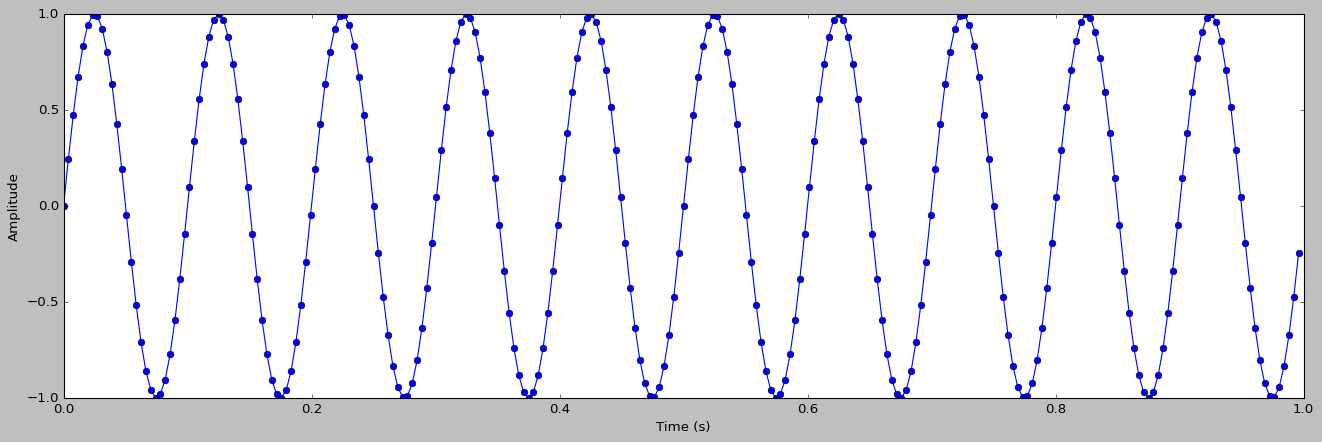

In [7]:
frequency = 10 #Hz
sample_rate = 256 #samples per second
duration = 1 # second

x, y = get_wave(frequency, sample_rate, duration)
plt.figure(figsize=(20,6))
plt.plot(x,y, '-bo')
plt.ylabel('Amplitude')
plt.xlabel('Time (s)');

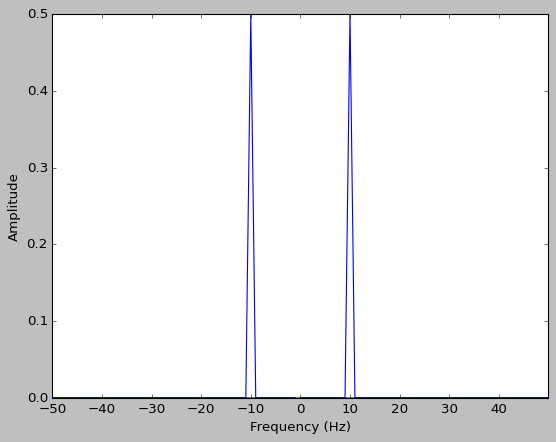

In [8]:
plt.plot(np.fft.fftfreq(sample_rate, d=1/sample_rate), abs(np.fft.fft(y))/256)
plt.ylabel('Amplitude')
plt.xlabel('Frequency (Hz)')
plt.xlim(-50,50)
plt.xticks(range(-50,50, 10));

- Es importante notar la frecuencia negativa.

## Ejemplo real

In [104]:
file_path = '/home/luis/git/educational-notebooks/13.1072.csv'
input_data = np.genfromtxt(file_path, delimiter=",")
data = input_data[:,7][:50000]
raw_fft = np.fft.fft(data)
raw_freq = np.fft.fftfreq(data.shape[0], d=1/data.shape[0])

Text(0.5, 0, 'Time (s)')

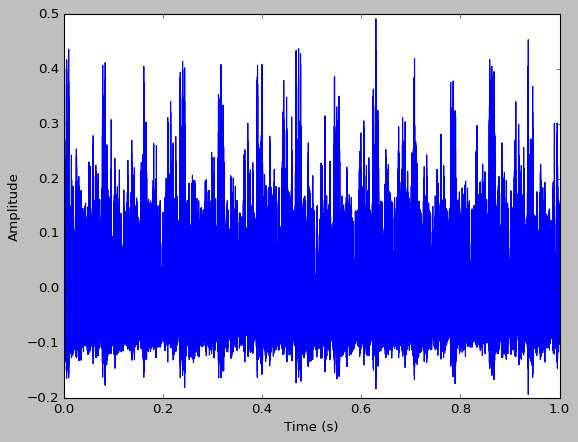

In [105]:
plt.plot(np.linspace(0, 1, 50000), data)
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')

Text(0.5, 0, 'Frequency (Hz)')

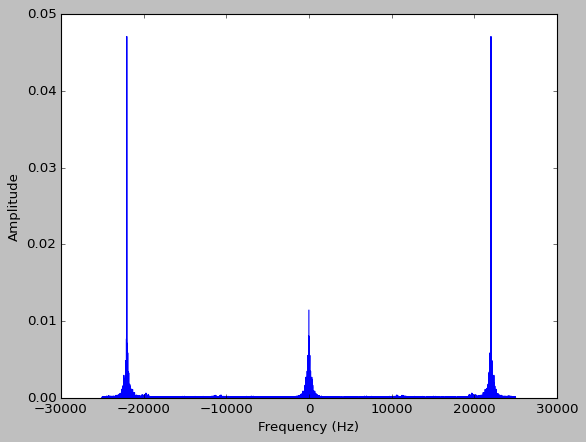

In [106]:
plt.plot(raw_freq, abs(raw_fft)/data.shape[0])
plt.ylabel('Amplitude')
plt.xlabel('Frequency (Hz)')

## ¿Qué es el FFT? ¿En qué se diferencia del DFT?

FFT, por sus siglas en inglés, "Fast Fourier Transform" es una implementación computacionalmente eficiente para el DFT. La complejidad es un área de estudio de eficiencia de algoritmos. Dos algoritmos podrían tener las mismas entradas y salidas, pero su costo computacional podría ser signficativamente distinto.

In [ ]:
def get_total_time(lp):
    timings = list(lp.get_stats().timings.items())
    units = lp.get_stats().unit
    total_time = sum(t[2] for t in timings[0][1]) * units

    return total_time

def plot_complexity():
    list_rate = [64, 128, 256, 512, 1024, 2048, 4096, 8192]
    fft_time = []
    dft_time = []

    for rate in list_rate:
        x, y = get_wave(60, rate, 1)
        lp = LineProfiler()
        lp_wrapper = lp(get_frequency_domain)
        lp_wrapper(y)
        fft_time.append(get_total_time(lp))

        lp = LineProfiler()
        lp_wrapper = lp(dft)
        lp_wrapper(y)
        dft_time.append(get_total_time(lp))
    
    fig, ax1 = plt.subplots(figsize=(20,6))
    ax2 = ax1.twinx()
    ax1.set_ylabel('FFT Time (s)')
    ax2.set_ylabel('DFT Time (s)')
    ax1.set_xlabel('Sample Rate')
    ax1.plot(list_rate, fft_time, '-bo', label='FFT')
    ax2.plot(list_rate, dft_time, '-r*', label='DFT')
    ax1.grid()
    ax1.set_title("FFT vs DFT")
    fig.legend(loc="upper left")

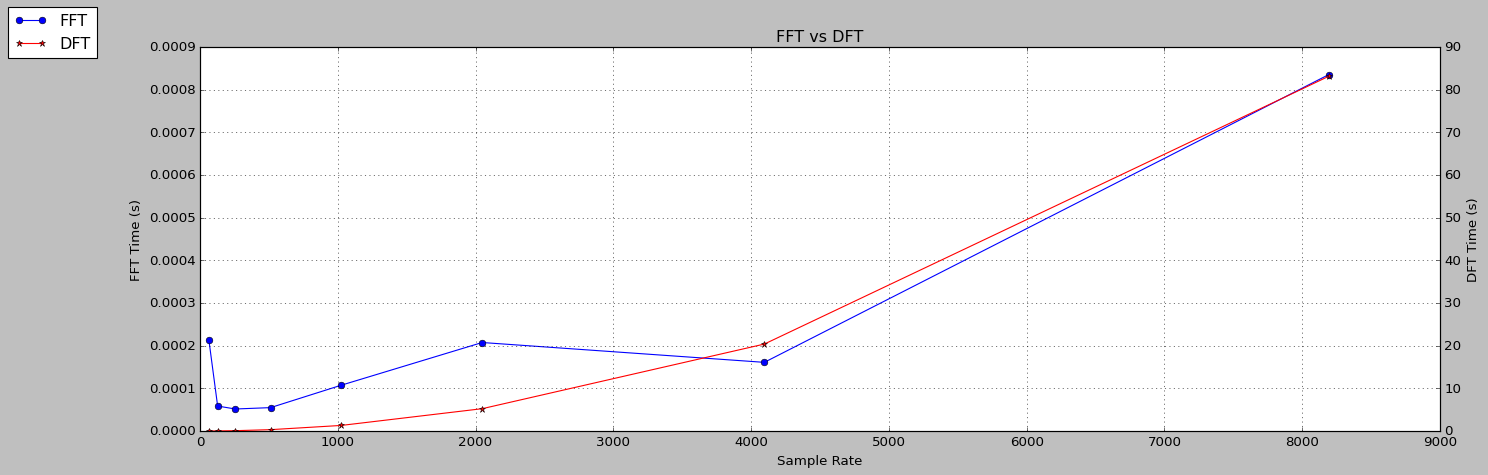

In [101]:
plot_complexity()

In [102]:
lp = LineProfiler()
lp_wrapper = lp(get_frequency_domain)
x, y = get_wave(60, 8192, 1)
lp_wrapper(y)
lp.print_stats()

Timer unit: 1e-09 s

Total time: 0.000565602 s
File: /tmp/ipykernel_2104/3477968570.py
Function: get_frequency_domain at line 13

Line #      Hits         Time  Per Hit   % Time  Line Contents
    13                                           def get_frequency_domain(series):
    14         1     561202.0 561202.0     99.2      series_fft = abs(np.fft.fft(series))
    15         1       3800.0   3800.0      0.7      series_fft_half = series_fft[0:int(len(series)//2)]
    16                                           
    17         1        600.0    600.0      0.1      return series_fft_half



In [103]:
lp = LineProfiler()
lp_wrapper = lp(dft)
x, y = get_wave(60, 8192, 1)
lp_wrapper(y)
lp.print_stats()

Timer unit: 1e-09 s

Total time: 83.4824 s
File: /tmp/ipykernel_2104/3477968570.py
Function: dft at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def dft(signal):
     2         1       1500.0   1500.0      0.0      N = len(signal)
     3         1      30000.0  30000.0      0.0      dft_result = np.zeros(N, dtype=complex)
     4                                               
     5      8193    2685701.0    327.8      0.0      for k in range(N):
     6  67117056        2e+10    230.4     18.5          for n in range(N):
     7  67108864        7e+10   1013.5     81.5              dft_result[k] += signal[n] * np.exp(-2j * np.pi * k * n / N)
     8         1     144800.0 144800.0      0.0      series_fft = abs(dft_result)
     9         1      18300.0  18300.0      0.0      series_fft_half = series_fft[0:int(N//2)]
    10                                               
    11         1       4700.0   4700.0      0.

## 1.1. Aliasing (solapamiento)

El aliasing ocurre cuando la frecuencia de muestreo es menor que la frecuencia de Nyquist. La frecuencia de Nyquist es la mitad de la frecuencia de muestreo.

Este fenómeno es más fácil de visualizar cuando para una misma tasa de muestreo, tenemos dos señales con frecuencias distintas, cuya relación sigue la siguiente formula:


$$
\begin{align}
f_\text{percibida} = |f-f_s \cdot \text{NINT}(\frac{f}{f_s}) |
\end{align}
$$

## Ejemplo simple

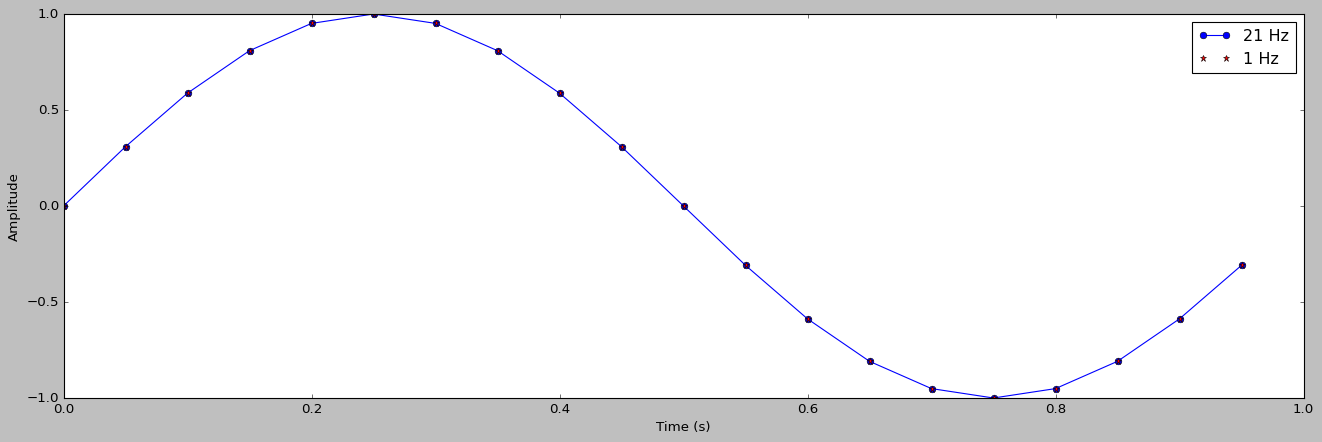

In [12]:
x_1, y_1 = get_wave(21, 20, 1) #45
x_2, y_2 = get_wave(1, 20, 1)
plt.figure(figsize=(20,6))
plt.plot(x_1,y_1, '-bo', label='21 Hz')
plt.plot(x_2, y_2, 'r*', label='1 Hz')
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')
plt.legend()

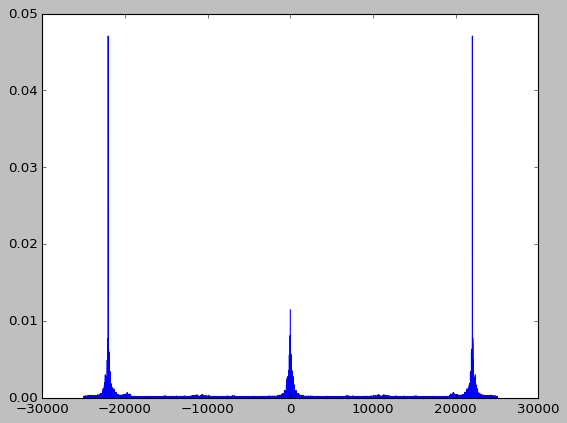

In [107]:
plt.plot(raw_freq, abs(raw_fft)/data.shape[0])

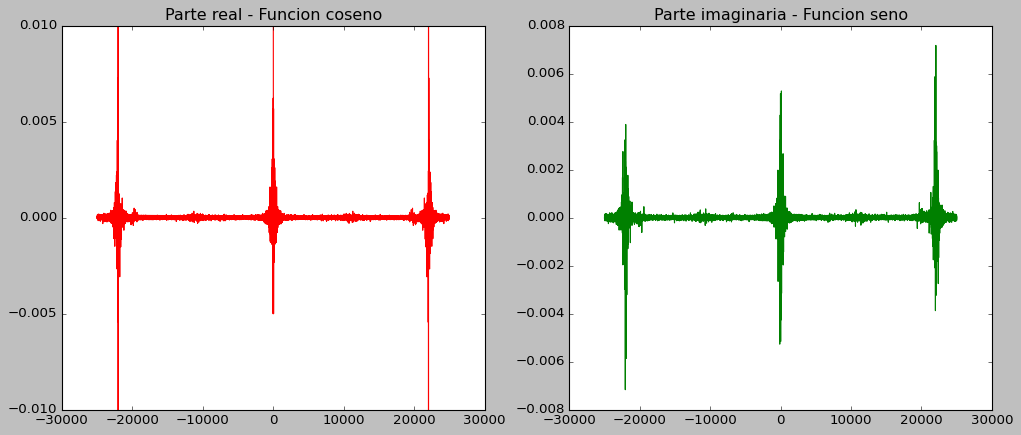

In [108]:
fig, axis = plt.subplots(1, 2)
fig.set_figwidth(15)
axis[0].plot(raw_freq, raw_fft.real/data.shape[0], 'r')
axis[0].set_ylim([-0.01, 0.01])
axis[0].set_title("Parte real - Funcion coseno")

axis[1].plot(raw_freq, raw_fft.imag/data.shape[0], 'g')
axis[1].set_title("Parte imaginaria - Funcion seno")
plt.show() 

# 2. Transformada de Hilbert

 $$
 \begin{align}
  H({\omega}) =
    \begin{cases}
      1, & \omega > 0\\
      0, & \omega = 0\\
      -1, & \omega < 0
    \end{cases}       
\end{align}
$$

Numericamente y usando la transforma discreta de Fourier se aproxima la transformada de Hilbert con los siguientes valores

 $$
 \begin{align}
  H({\omega}) =
    \begin{cases}
      2, & f < f_N\\
      0, & f >  f_N\\
      1, & f = 0
    \end{cases}       
\end{align}
$$

Donde $f_N$ es la frecuencia de Nyquist

## 2.1. Ejemplo simple

In [79]:
x, y = get_wave(frequency, sample_rate, duration)
y += 0.5*np.random.normal(size=len(x))

# 3. Señal Analítica (Análisis de envolvente)

La señal analítica se define como

$$
\begin{align}
z(t) = s(t) + i \hat{s}(t)
\end{align}
$$

Donde $\hat{s}$ es la transformada de Hilbert

## 3.1. Ejemplo simple

In [80]:
y_analytic_signal = get_analytic_signal2(y)
y_envelope = get_amplitude_envelope(y_analytic_signal)
y_instantaneous_phase = get_instantaneous_phase(y_analytic_signal)
y_intantaneous_frequency = get_intantaneous_frequency(y_instantaneous_phase)

c:\Python\Python310\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


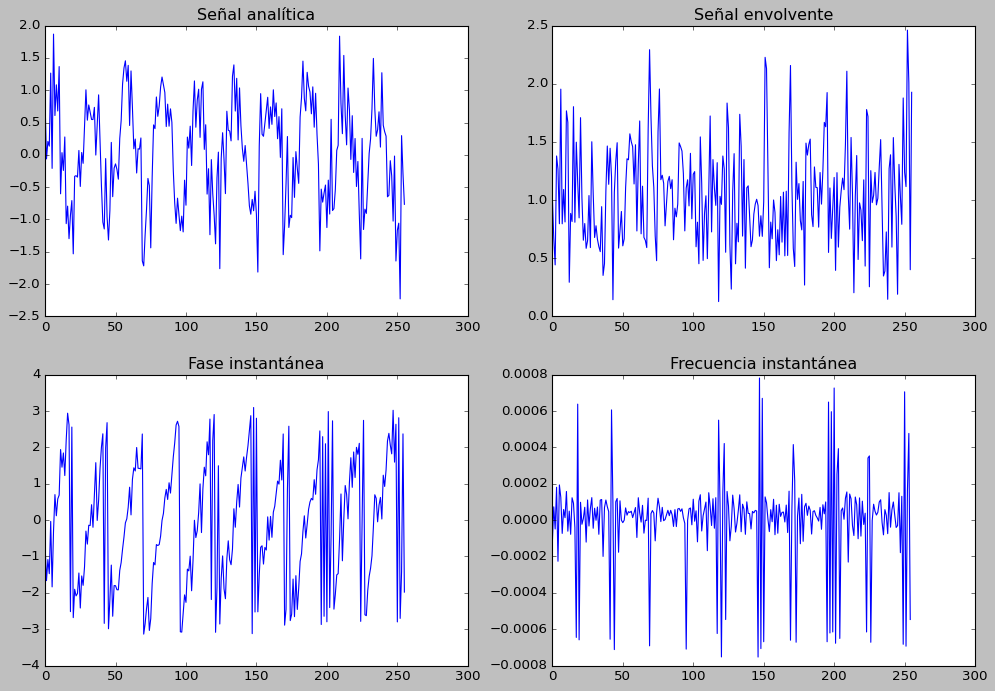

In [81]:
fig, axis = plt.subplots(2, 2)
fig.set_figwidth(15)
fig.set_figheight(10)
axis[0, 0].plot(y_analytic_signal)
axis[0, 0].set_title("Señal analítica")

axis[0, 1].plot(y_envelope)
axis[0, 1].set_title("Señal envolvente")

axis[1, 0].plot(y_instantaneous_phase)
axis[1, 0].set_title("Fase instantánea")

axis[1, 1].plot(y_intantaneous_frequency)
axis[1, 1].set_title("Frecuencia instantánea")
plt.show() 

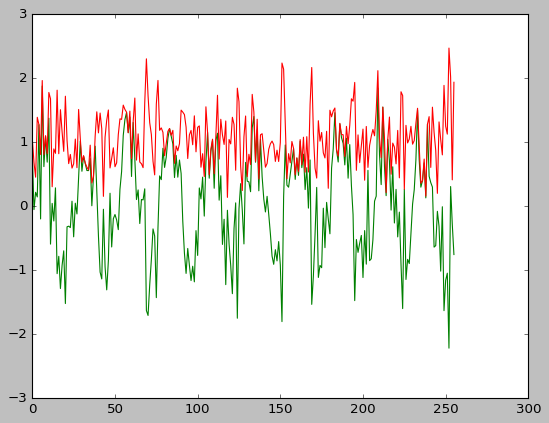

In [82]:
plt.plot(y, 'g')
plt.plot(y_envelope, 'r')

In [83]:
y_analytic_signal = get_analytic_signal2(data)
y_envelope = get_amplitude_envelope(y_analytic_signal)
y_instantaneous_phase = get_instantaneous_phase(y_analytic_signal)
y_intantaneous_frequency = get_intantaneous_frequency(y_instantaneous_phase)

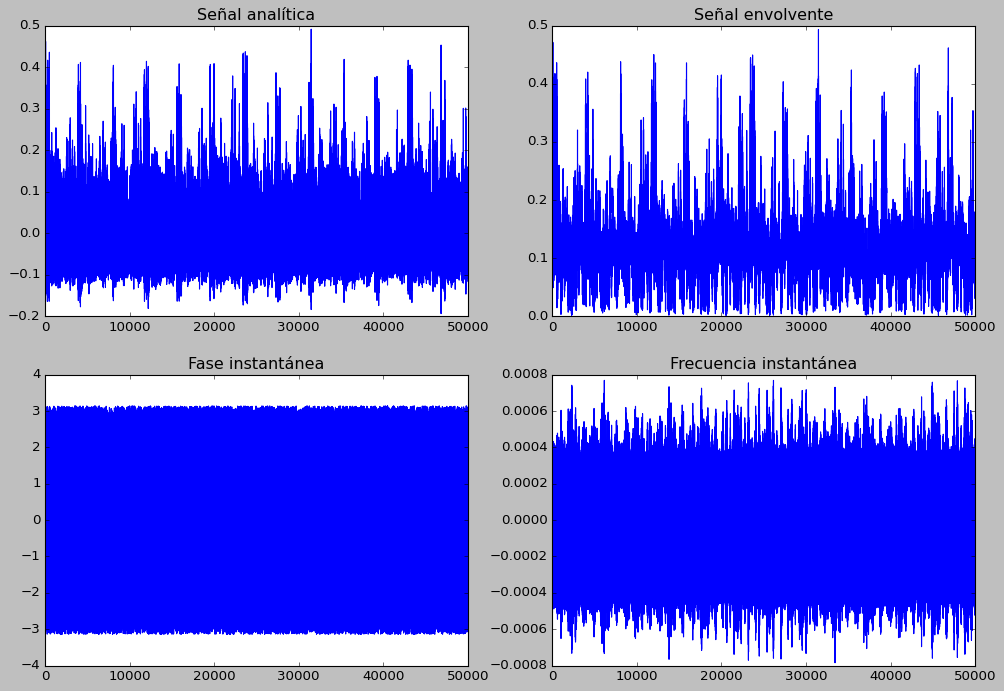

In [84]:
fig, axis = plt.subplots(2, 2)
fig.set_figwidth(15)
fig.set_figheight(10)
axis[0, 0].plot(y_analytic_signal)
axis[0, 0].set_title("Señal analítica")

axis[0, 1].plot(y_envelope)
axis[0, 1].set_title("Señal envolvente")

axis[1, 0].plot(y_instantaneous_phase)
axis[1, 0].set_title("Fase instantánea")

axis[1, 1].plot(y_intantaneous_frequency)
axis[1, 1].set_title("Frecuencia instantánea")
plt.show() 

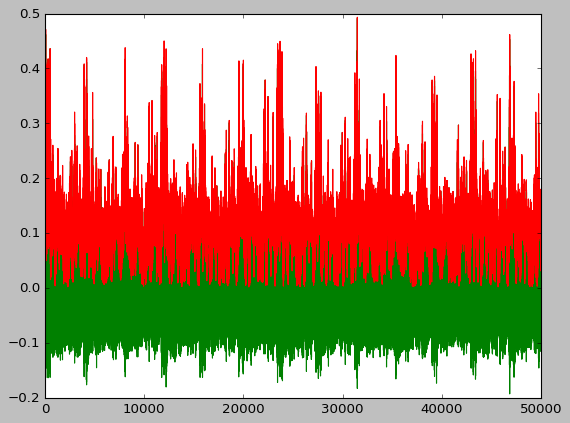

In [85]:
plt.plot(data, 'g')
plt.plot(y_envelope, 'r')

(0.0, 50.0)

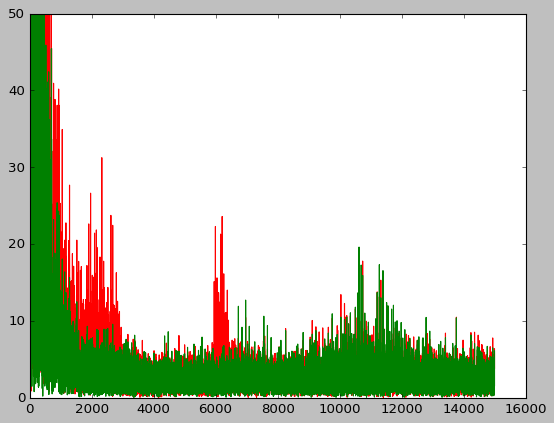

In [86]:
plt.plot(abs(np.fft.fft(y_envelope)[0:len(data)//2])[0:15000], 'r')
plt.plot(abs(np.fft.fft(data)[0:len(data)//2])[0:15000], 'g')
plt.ylim([0, 50])

# 4. Decomposición empírica de modos

In [87]:
def sifting_imf(signal):
    imf = signal
    standard_deviation = float('inf')

    while standard_deviation > 0.2:
        maxima, minima = identify_extrema(imf)
        upper_envelope = CubicSpline(maxima[:,0], maxima[:,1])(np.arange(len(signal)))
        lower_envelope = CubicSpline(minima[:,0], minima[:,1])(np.arange(len(signal)))

        mean_envelope = (upper_envelope + lower_envelope)/2
        previous_imf = imf
        imf = imf - mean_envelope
        standard_deviation = np.sum(previous_imf - imf)**2 / np.sum(previous_imf**2)

    return imf
    
def identify_extrema(signal):
    delta = np.diff(signal)
    maxima = np.array([[i, signal[i]] for i in range(1, len(delta)) if delta[i-1] > 0 > delta[i]])
    minima = np.array([[i, signal[i]] for i in range(1, len(delta)) if delta[i-1] < 0 < delta[i]])

    return maxima, minima

def emphirical_decomposition_mode(signal, max_imfs=10):
    imfs=[]
    residual = signal

    for _ in range(max_imfs):
        imf = sifting_imf(residual)
        imfs.append(imf)
        residual = residual - imf

        if np.all(np.abs(residual) < 1e-2):
            break
    
    return imfs, residual

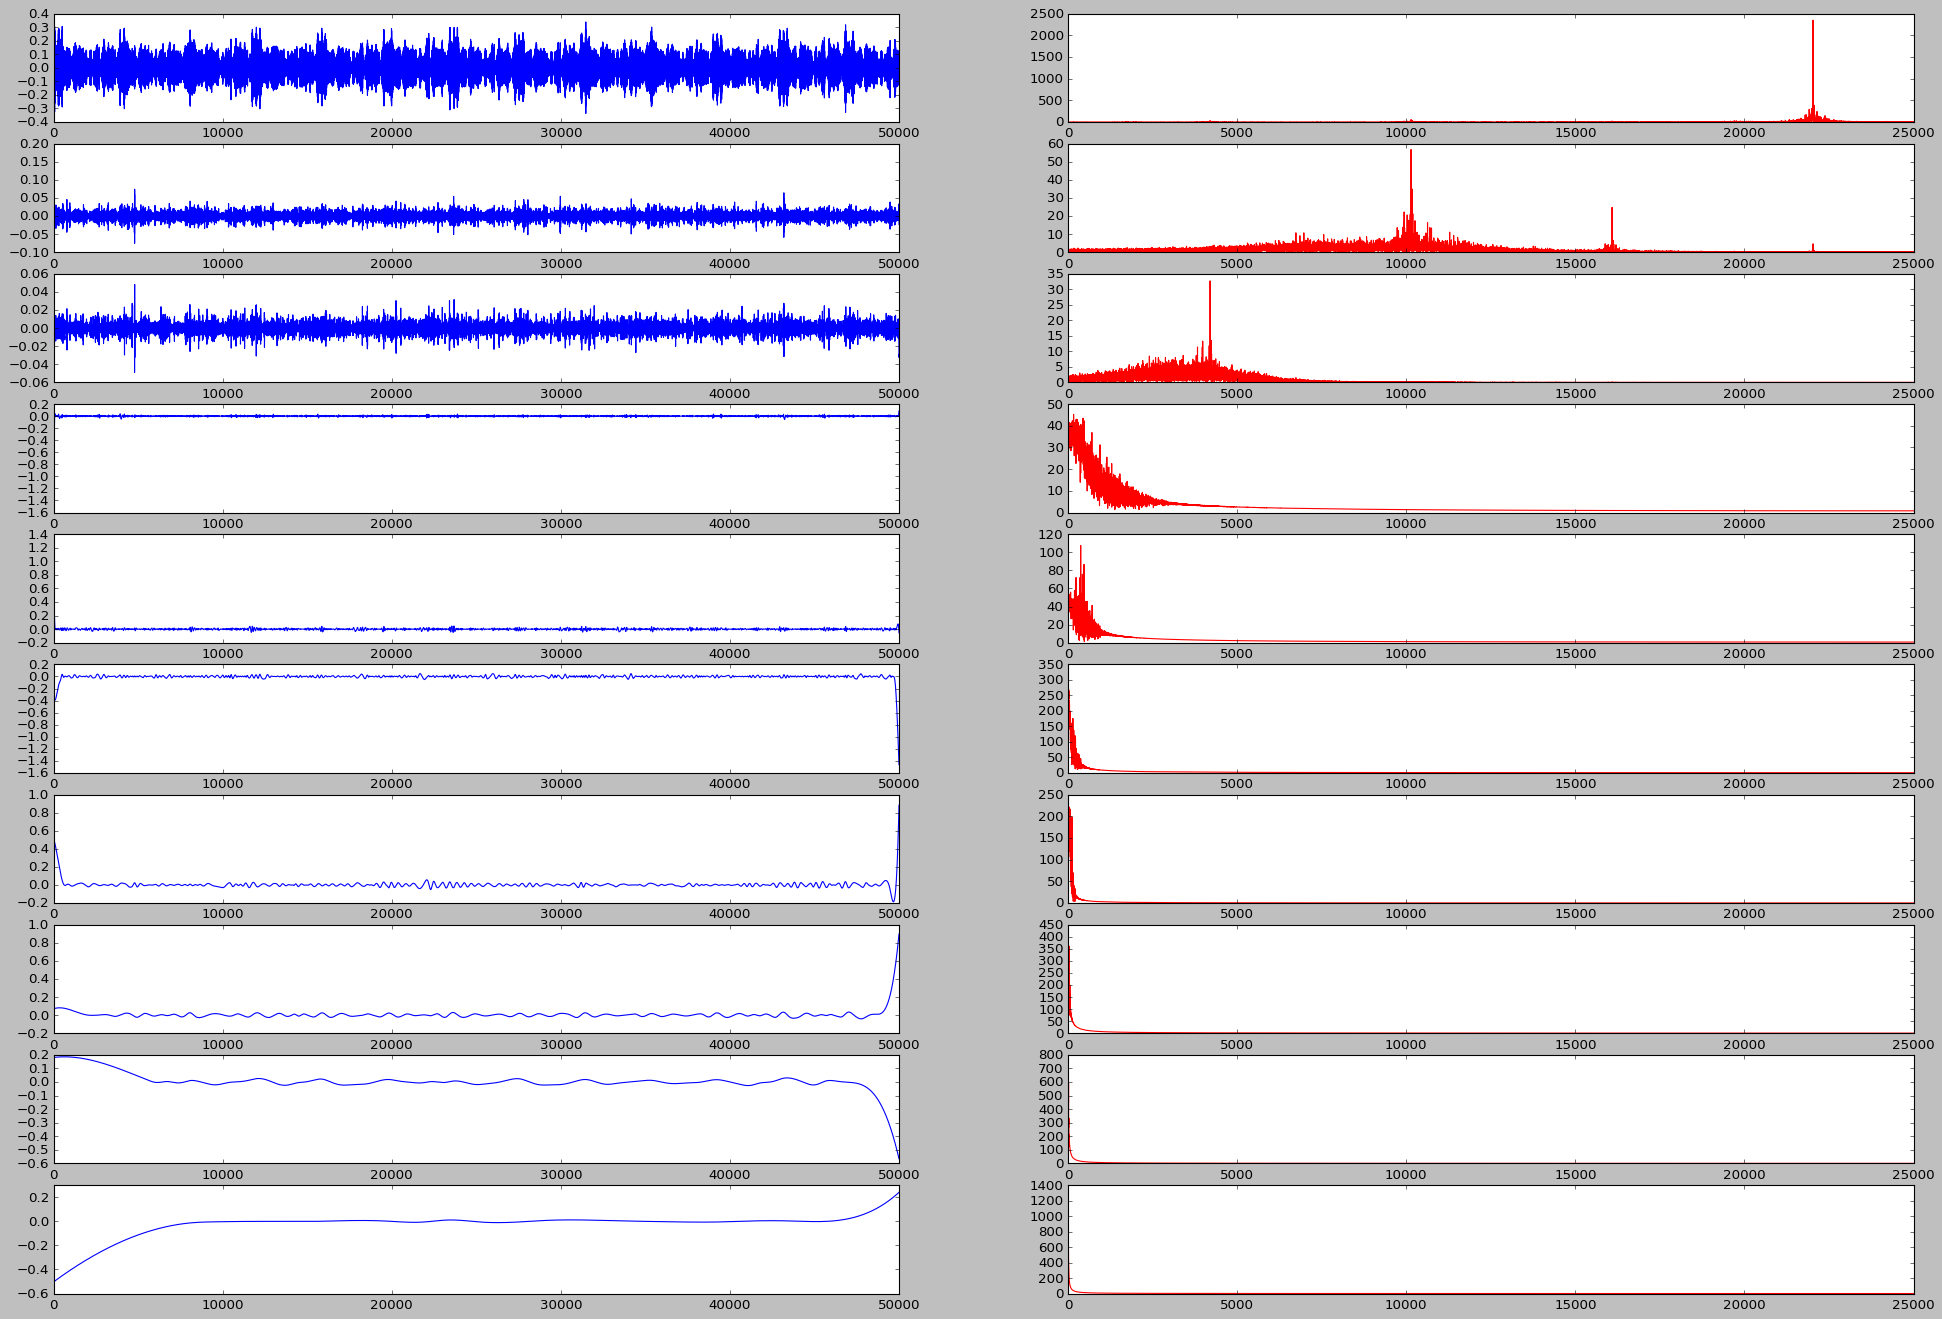

In [102]:
fig, axis = plt.subplots(10, 2)
fig.set_figwidth(30)
fig.set_figheight(20)
for i in range(10):
    axis[i, 0].plot(imfs[i])
    axis[i, 1].plot(abs(np.fft.fft(imfs[i]))[0:25000], color='r')
plt.show() 